In [ ]:
from os.path import exists
import re
from glob import glob
import numpy as np
import pandas as pd
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import randomized_svd
from matplotlib import pyplot as plt
import matplotlib
from wordcloud import WordCloud

In [ ]:
drive.mount('/content/drive')

In [ ]:
# dados extraídos de: https://dadosabertos.camara.leg.br/swagger/api.html#staticfile
path_padrao = '/content/drive/MyDrive/bmt_projeto_final_preprocessed.gzip'
if not exists(path_padrao):
  data_path = {
      'proposicoes': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoes/*.xlsx',
      'autores': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesAutores/*.xlsx',
      'temas': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesTemas/*.xlsx',
      }
# pre-processed output filename
output = '/content/drive/MyDrive/bmt_projeto_final_preprocessed.gzip'

In [ ]:
if not exists(output):
  # read xlsx files
  data = {}
  for k, p in data_path.items():
    print(f'reading {k} in {p}...')
    data[k] = pd.concat([pd.read_excel(f) for f in glob(p)])
  # filtering
  # Apenas "Projetos de Lei" e propostos por "Deputados"
  data['proposicoes'] = data['proposicoes'].loc[data['proposicoes']['siglaTipo'] == 'PL']
  data['autores'] = data['autores'].loc[data['autores']['tipoAutor'] == 'Deputado']
  # merging
  dataset = data['proposicoes'].merge(data['autores'], suffixes=('_proposicao', '_autor'), left_on='id', right_on='idProposicao', how='left')
  dataset = dataset.merge(data['temas'], left_on='uri', suffixes=('_proposicao', '_tema'), right_on='uriProposicao', how='left')
  dataset = dataset[['id', 'ano_proposicao', 'ementa', 'ementaDetalhada', 'keywords', 'tema', 'nomeAutor', 'siglaPartidoAutor', 'siglaUFAutor', 'ordemAssinatura']]
  dataset = dataset.rename(columns={'ano_proposicao': 'ano'})
  dataset.to_json(output, compression='gzip')
else:
  # read existing file
  dataset = pd.read_json(output, compression='gzip')


In [ ]:
#Execução Opcional

#Lista de partidos antes da correção
listaPartidos = dataset['siglaPartidoAutor'].unique()
listaPartidos = listaPartidos[~pd.isnull(listaPartidos)]
#print(listaPartidos)
print('Lista Ordenada de Partidos\n')
listaPartidosOrdenados = np.sort(listaPartidos)
print(listaPartidosOrdenados)

**Nomes a serem consertados:**
01. 'PATRI' => 'PATRIOTA'
02. ??? 'PCDB' => 'PCdoB' ???
03. 'PCDOB' => 'PCdoB'
04. 'SOLIDARIED' => 'SOLIDARI'
05. 'SD' => 'SOLIDARI'
06. 'SDD' => 'SOLIDARI'
07. 'PTDOB' => 'PTdoB'
08. 'SPART' => 'NI'
09. 'S.PART.' => 'NI'
10. Nulo (NaN) => 'NI'

In [ ]:
#Corrigindo Partidos com Nomes Errados e atribuindo "NI" (Não Identificado) aos nulos

datasetC = dataset

datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'PATRI' , 'PATRIOTA' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'PCDB' , 'PCdoB' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'PCDOB' , 'PCdoB' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'SOLIDARIED' , 'SOLIDARI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'SD' , 'SOLIDARI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'SDD' , 'SOLIDARI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'PTDOB' , 'PTdoB' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where( ((datasetC['siglaPartidoAutor'] == 'PRP') & (datasetC['ano'] <= 1965)) , 'PRP*' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'SPART' , 'NI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'S.PART.' , 'NI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(datasetC['siglaPartidoAutor'] == 'PNI' , 'NI' , datasetC['siglaPartidoAutor'])
datasetC['siglaPartidoAutor'] = np.where(pd.isnull(datasetC['siglaPartidoAutor']) , 'NI' , datasetC['siglaPartidoAutor'])


#Retirando os projetos com id duplicado por ser assinado por mais de um autor
#len(datasetC['id'].unique())
datasetC = datasetC.drop_duplicates('id')

#Verificando a lista dos partidos 
#listaPartidosC = datasetC['siglaPartidoAutor'].unique()
#listaPartidosC = listaPartidosC[~pd.isnull(listaPartidosC)]
#print('Lista Ordenada Corrigida de Partidos\n')
#listaPartidosOrdenadosC = np.sort(listaPartidosC)
#print(listaPartidosOrdenadosC)

#datasetC2 = datasetC
#datasetC2 = datasetC2.loc[datasetC2['ano'] >= 1966]
#datasetC2 = datasetC2.loc[datasetC2['ano'] <= ano_end]
#datasetC2 = datasetC2.loc[datasetC2['siglaPartidoAutor'] == 'PRP*']
#datasetC2

> "*Desde fevereiro de 2022, o Brasil tem trinta e dois partidos políticos legalizados no Tribunal Superior Eleitoral.*" (Wikipédia)

Nº   | Partido | Situação | Rebranding | Incorporação/Fusão
-----|---------|----------|------------|------------- 
[36] | Agir (sem proposição) | Ativo e presente no dataset | 'PTC' | 'PJ', 'PRN'
[70] | 'AVANTE' | Ativo e presente no dataset | 'PTdoB' | - 
[23] | 'CIDADANIA' | Ativo e presente no dataset | 'PPS'| - 
[27] | Democracia Cristã (sem proposição) | Ativo e presente no dataset | 'PSDC' | - 
[15] | 'MDB' [+ 'PMDB'] | Ativo e presente no dataset | 'MDB*', 'PMDB' | 'PP**'
[21] | 'PCB' | Ativo e presente no dataset | - | - 
[65] | 'PCdoB' | Ativo e presente no dataset | - | - 
[33] | 'PMN' | Ativo e presente no dataset | - | - 
[35] | 'PMB' | Ativo e presente no dataset | - | - 
[45] | 'PSDB' | Ativo e presente no dataset | - | - 
[12] | 'PDT' | Ativo e presente no dataset | - | - 
[13] | 'PT' | Ativo e presente no dataset | - | - 
[22] | 'PL' | Ativo e presente no dataset | 'PR' | 'PRONA' 
[30] | 'NOVO' | Ativo e presente no dataset | - | - 
[28] | 'PRTB' | Ativo e presente no dataset | - | - 
[90] | 'PROS' | Ativo e presente no dataset | - | - 
[20] | 'PSC' | Ativo e presente no dataset | - | - 
[55] | 'PSD' | Ativo e presente no dataset | - | - 
[50] | 'PSOL' | Ativo e presente no dataset | - | - 
[40] | 'PSB' | Ativo e presente no dataset | - | - 
[16] | 'PSTU' | Ativo e presente no dataset | - | - 
[14] | 'PTB' | Ativo e presente no dataset | - | 'PAN'  
[43] | 'PV' | Ativo e presente no dataset | - | - 
[51] | 'PATRIOTA' | Ativo e presente no dataset | 'PEN' | 'PRP'
[19] | 'PODE' | Ativo e presente no dataset | 'PTN' | 'PHS' 
[11] | 'PP' | Ativo e presente no dataset | 'UDN', 'ARENA', 'PDS', 'PPR', 'PPB' | 'PRP*', 'PSP', 'PDC', 'PTR, 'PST' 
[18] | 'REDE' | Ativo e presente no dataset | - | - 
[10] | 'REPUBLIC' | Ativo e presente no dataset | 'PMR', 'PRB' | 
[77] | 'SOLIDARI' | Ativo e presente no dataset | 'SDD', 'SD' 
[44] | 'UNIÃO' | Ativo e presente no dataset | 'PFL' | 'DEM' 
[29] | PCO (Partido da Causa Operária) | Ativo e não-presente no dataset (***sem proposição***) | - | - 
[80] | UP  (Unidade Popular) | Ativo e não-presente no dataset (***sem proposição***) | - | - 
N/A  | 'PRT' (1948~1965) | Extinto e não-incorporado, mas presente no dataset | - | - 
N/A  | 'MTR' (1961~1965) | Extinto e não-incorporado, mas presente no dataset | - | - 
N/A  | 'PS'  (1986~1989) | Extinto e não-incorporado, mas presente no dataset | - | - 
N/A  | 'PLP' (1988~1990) | Extinto e não-incorporado, mas presente no dataset | - | - 
N/A  | 'PRS' (1990~1992) | Extinto e não-incorporado, mas presente no dataset | - | - 

> Atenção: as proposições do 'PRP*' até 1965 são do "Partido de Representação Popular", quando tornou-se 'ARENA'; e de 1989 em diante 'PRP' é a sigla do "Partido Republicano Progressista", atual 'PATRIOTA'.

> 'PP**' é "Partido Popular", incorporado ao PMDB em 1982.

> Aparentemente, 'PNI' corresponde a "Partido Não Identificado/Informado".


# Possibilidades interessantes


1.   Por década sem partido (8 décadas)
2.   Por década por tema 
3.   Principais partidos
4.   Partidos que mudaram de nome (antes e depois)

# "Descoberto"

1.   Fazer lista ordenada dos partidos com mais proposições, contabilizando sobre o percentual total => **Tabela Ordenada de Proposições por Partido**; 
2.   Fazer lista ordenadas dos temas com mais proposições, contabilizando sobre o percentual total => **Tabela Ordenada de Temas**
3.   Fazer lista de partidos que mudaram de nome, relacionando-os, bem como o ano em que mudaram de nome => tabela **Mudança de Nomes** ; 




# Ordenando por Tema

In [ ]:
#Execução Opcional

#São 32 temas, sendo que muitas proposições estão com o tema nulo 
listaTemas = datasetC['tema'].unique()
listaTemas = listaTemas[~pd.isnull(listaTemas)]
#print(listaTemas)
print('Lista Ordenada de Temas\n')
listaTemasOrdenados = np.sort(listaTemas)
print(listaTemasOrdenados)

In [ ]:
#Execução Opcional

#São 50.786 proposições com tema nulo, e 135.326 proposições com tema explicitado, totalizando as sabidas 186.112 proposições
qtdTemas = datasetC['tema']
print(qtdTemas)

#Total de temas nulos
print(f'Qtd. Total de Proposições: 124.848')
print(f'Qtd. Temas Nulos: {np.count_nonzero(pd.isnull(qtdTemas))}')

#Total de temas não-nulos
print(f'Qtd. Temas Não-Nulos: {np.count_nonzero(~pd.isnull(qtdTemas))}')

totalSabido = 74288
totalGeral = 0
i=1
print('Id.| Tema | Absoluto | Relativo')
for tema in listaTemasOrdenados:
  totalTema = (datasetC.tema == tema).sum()
  percTema = totalTema/totalSabido*100
  print(f'{i} | {percTema:.2f}% | {tema} | {totalTema}')
  totalGeral += totalTema
  i+=1
print(f'\nTotal Calculado: {totalGeral}')
print(f'Total Sabido: {totalSabido}')

#Tabela Ordenada de Temas

Ord.| Relativo | Descrição do Tema | Absoluto
----|-------------------|--------------|-----------
01 | 12.35% | Administração Pública | 9177
02 | 11.83% | Trabalho e Emprego | 8787
12 | 6.32% | Direito Penal e Processual Penal | 4693

10 | 4.27% | Direito Civil e Processual Civil | 3170
8 | 3.06% | Comunicações | 2271
9 | 3.49% | Defesa e Segurança | 2589
4 | 2.81% | Cidades e Desenvolvimento Urbano | 2090
3 | 2.10% | Arte, Cultura e Religião | 1558
2 | 1.83% | Agricultura, Pecuária, Pesca e Extrativismo | 1360
5 | 0.66% | Ciência, Tecnologia e Inovação | 493
6 | 0.00% | Ciências Exatas e da Terra | 3
7 | 0.00% | Ciências Sociais e Humanas | 3

11 | 0.10% | Direito Constitucional | 78

13 | 2.44% | Direito e Defesa do Consumidor | 1816
14 | 0.44% | Direito e Justiça | 329
15 | 7.52% | Direitos Humanos e Minorias | 5589
16 | 2.68% | Economia | 1989
17 | 6.12% | Educação | 4550
18 | 1.64% | Energia, Recursos Hídricos e Minerais | 1221
19 | 1.24% | Esporte e Lazer | 921
20 | 0.85% | Estrutura Fundiária | 632
21 | 6.03% | Finanças Públicas e Orçamento | 4481
22 | 3.25% | Homenagens e Datas Comemorativas | 2418
23 | 3.39% | Indústria, Comércio e Serviços | 2518
24 | 2.23% | Meio Ambiente e Desenvolvimento Sustentável | 1656
25 | 1.67% | Política, Partidos e Eleições | 1237
26 | 2.76% | Previdência e Assistência Social | 2048
27 | 0.08% | Processo Legislativo e Atuação Parlamentar | 59
28 | 0.17% | Relações Internacionais e Comércio Exterior | 127
29 | 4.59% | Saúde | 3411
31 | 0.17% | Turismo | 130
32 | 3.88% | Viação, Transporte e Mobilidade | 2884

# Ordenando por Partido

In [ ]:
#Execução Opcional

#Verificando a lista dos partidos 
listaPartidosC = datasetC['siglaPartidoAutor'].unique()
listaPartidosC = listaPartidosC[~pd.isnull(listaPartidosC)]
print('Lista Ordenada Corrigida de Partidos\n')
listaPartidosOrdenadosC = np.sort(listaPartidosC)
print(listaPartidosOrdenadosC)

#São 186.112 proposições, todas com partido identificado ou corrigido ('S.PART.' ou 'PNI')
listaProposicoesPartido = datasetC['siglaPartidoAutor']

#Total de proposições com partido
print(f'Qtd. Proposições Com Partido: {np.count_nonzero(pd.isnull(listaProposicoesPartido))}')

totalSabido = 186112
totalGeral = 0
i=1
print('Id.| Relativo | Partido | Absoluto ')
for partido in listaPartidosOrdenadosC:
  totalPartido = (datasetC.siglaPartidoAutor == partido).sum()
  percPartido = totalPartido/totalSabido*100
  print(f'{i} | {percPartido:.2f}% | {partido} | {totalPartido}')
  totalGeral += totalPartido
  i+=1
print(f'\nTotal Calculado: {totalGeral}')
print(f'Total Sabido: {totalSabido}')

#Tabela Ordenada de Proposições por Partido

Ord.| Relativo | Partido | Absoluto 
----|---------|----------|---------
01 | 13.19% | PT | 24539
02 | 9.01% | PMDB | 16764
03 | 5.91% | PSDB | 10997
04 | 5.43% | PSD | 10113
05 | 4.80% | PTB | 8942
06 | 4.34% | PSB | 8086
07 | 4.21% | PDT | 7829
08 | 3.40% | MDB* | 6331
09 | 3.01% | PFL | 5597
10 | 2.91% | PP | 5413
11 | 2.86% | ARENA | 5332
12 | 2.39% | PSL | 4454
13 | 2.34% | MDB | 4352
14 | 2.33% | DEM | 4343
15 | 2.25% | PL | 4192
16 | 2.25% | PDS | 4186
17 | 1.77% | PR | 3291
18 | 1.69% | UDN | 3136
19 | 1.50% | PCdoB | 2794
20 | 1.38% | PSOL | 2575
21 | 1.15% | PV | 2133
22 | 0.99% | PPS | 1844
23 | 0.91% | PODE | 1692
24 | 0.87% | REPUBLIC | 1613
25 | 0.83% | PSP | 1539
26 | 0.82% | PPB | 1521
27 | 0.82% | PRB | 1519
28 | 0.74% | SOLIDARI | 1384
29 | 0.60% | PROS | 1123
30 | 0.47% | NOVO | 878
31 | 0.46% | CIDADANIA | 863
32 | 0.37% | PDC | 695
33 | 0.26% | AVANTE | 484
34 | 0.24% | PATRIOTA | 444
35 | 0.23% | PTN | 437
36 | 0.20% | PRN | 375
37 | 0.19% | PHS | 359
38 | 0.18% | PST | 333
39 | 0.15% | UNIÃO | 286
40 | 0.15% | PMN | 284
41 | 0.15% | PRP* | 282
42 | 0.13% | PPR | 249
43 | 0.13% | PTdoB | 243
44 | 0.11% | PP** | 211
45 | 0.11% | REDE | 206
46 | 0.07% | PCB | 139
47 | 0.07% | PTR | 135
48 | 0.07% | PTC | 125
49 | 0.06% | PRONA | 105
50 | 0.04% | PRTB | 82
51 | 0.04% | PRP | 79
52 | 0.03% | PMB | 65
53 | 0.02% | PEN | 40
54 | 0.01% | PRT | 23
55 | 0.01% | PJ | 18
56 | 0.01% | PSDC | 18
57 | 0.01% | PSTU | 18
58 | 0.01% | PS | 13
59 | 0.01% | PAN | 12
60 | 0.00% | MTR | 9
61 | 0.00% | PRS | 7
62 | 0.00% | PMR | 6
63 | 0.00% | PLP | 2
64 | 0.89% | PSC | 1657
---| 10.37% | NI | 19296


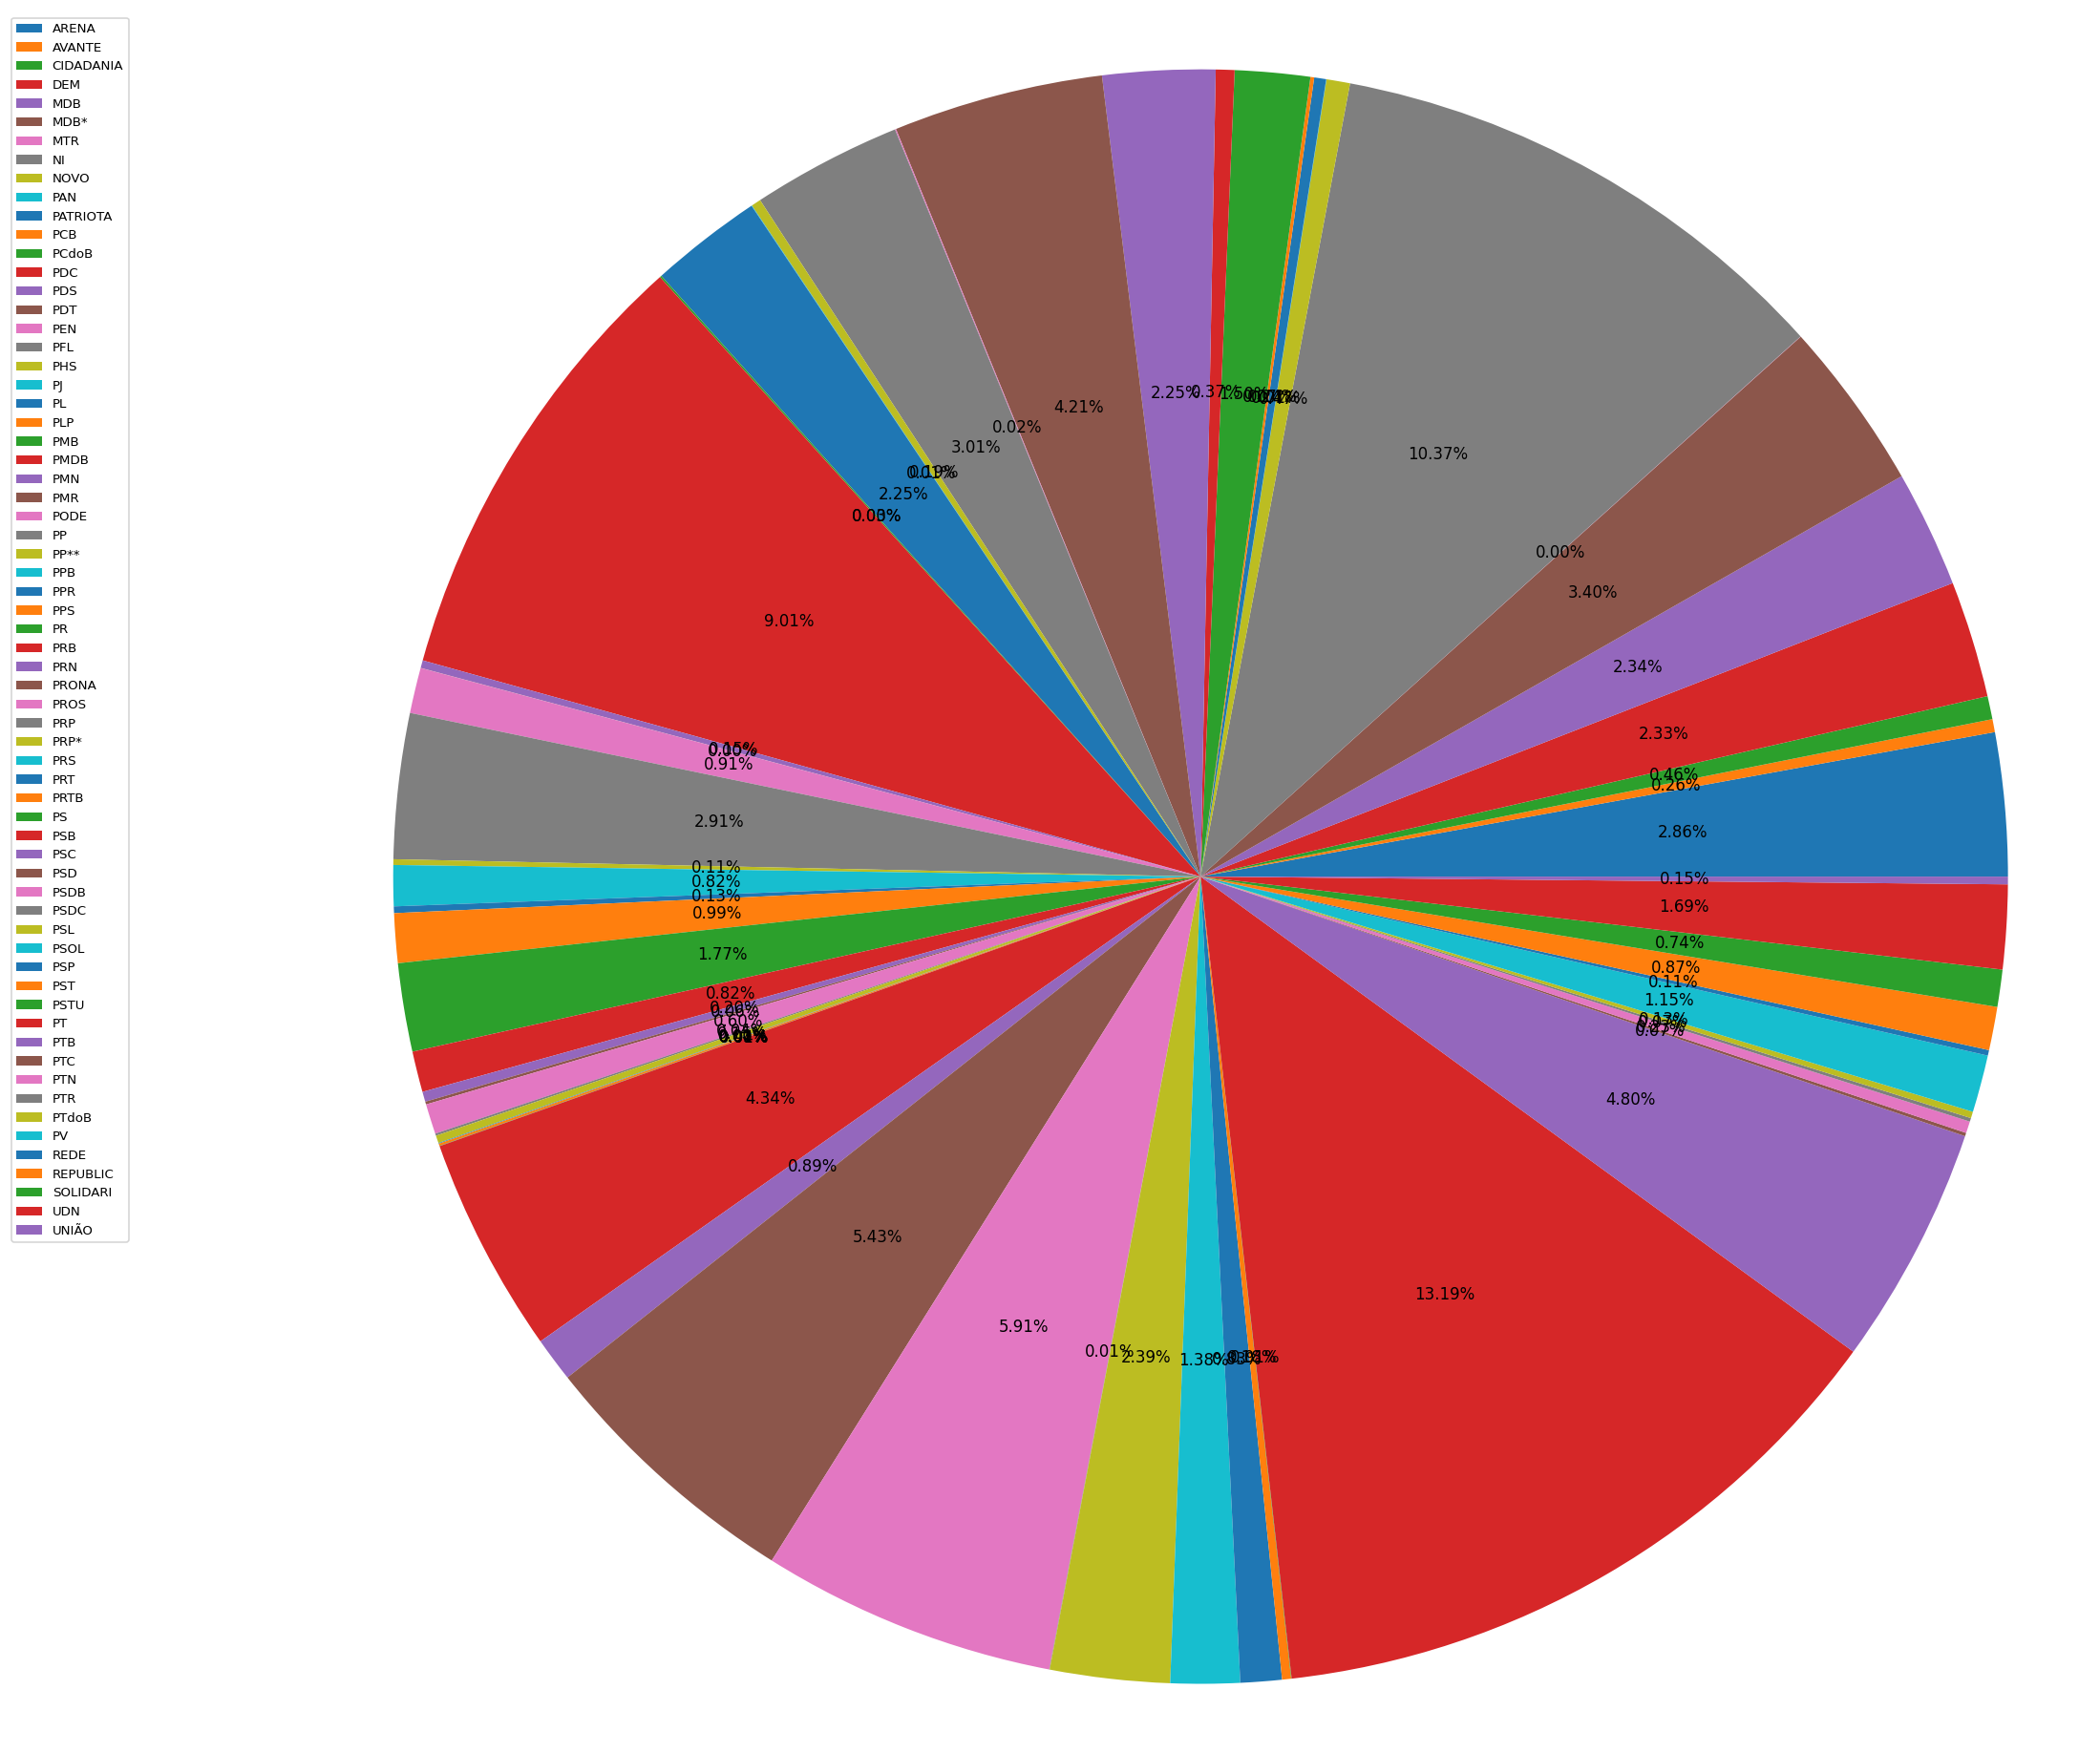

In [ ]:
proposicoesPorPartido = datasetC.groupby(['siglaPartidoAutor'])['siglaPartidoAutor'].count()

partido = []
total = []

for p, t in proposicoesPorPartido.items():
  partido.append(p)
  total.append(t)

plt.figure(figsize=(20,20), dpi=120)
plt.pie(total, autopct='%1.2f%%')
plt.legend(partido, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.axis('equal')
plt.show()

# Filtros

In [ ]:
# @title Filtros
ano_start = 1934 # @param {type:"slider", min:1934, max:2022, step:1}
ano_end = 2022 # @param {type:"slider", min:1934, max:2022, step:1}
partido = "" # @param ["", "ARENA", "AVANTE", "CIDADANIA", "DEM", "MDB", "MDB*", "MTR", "NOVO", "NI", "PAN",  "PATRIOTA", "PCB", "PCdoB", "PDC", "PDS", "PDT", "PEN", "PFL", "PHS", "PJ", "PL", "PLP", "PMB", "PMDB", "PMN", "PMR", "PODE", "PP", "PP**", "PPB", "PPR", "PPS", "PR", "PRB", "PRN", "PRONA", "PROS", 'PRP*', "PRP", "PRS", "PRT", "PRTB", "PS", "PSB", "PSC", "PSD", "PSDB", "PSDC", "PSL", "PSOL", "PSP", "PST", "PSTU", "PT", "PTB", "PTC", "PTN", "PTR", "PTdoB", "PV", "REDE", "REPUBLIC", "SOLIDARI", "UDN", "UNIÃO"]

# ["", "PT", "PR", "PDT", "PSDB", "PSOL", "PCdoB", "PSB", "PSD", "PV", "SOLIDARI", "PODE", "AVANTE", "PP", "REPUBLIC", "PTB", "PSL", "MDB", "CIDADANIA", "PL", "DEM", "PATRIOTA", "PSC", "UNIÃO", "NOVO", "PROS", "REDE", "S.PART.", "PODEMOS", "PMDB", "PRB", "SD", "REPUB", "Podemos", "PPS", "PHS", "PEN", "PATRI", "S/Partido", "PTC", "PTN", "SOLIDARIED", "PMN", "SemPartido", "PRP", "PTdoB", "PMB", "S Partido", "SDD", "PSDC", "PRTB", "Rede", "PMBD", "PC do B", "PC DOB", "S/Part", "PT -", "PC DO  B", "pRB", "psdb", "pp", "pdt", "prb", "pmdb", "pt", "Nn", "nm", "NN", "AA", "PSBD", "dem", "PCDB", "PFL", "DOM", "PSBB", "PAN", "S/PARTIDO", "PRONA", "PMR", "PPB", "SPART", "PST", "PBDB", "PCDOB", "PPR", "PSTU", "PRN", "PDS", "PDC", "PTR", "PCB", "PRS", "PLP", "PTDOB", "PJ", "PDB", "PS", "PDMB", "PMDF", "MDB*", "ARENA", "PP**", "PNI", "Arena", "UDN", "MEB", "MTR", "PSP", "MRT", "PRT"]
# ["", "ARENA", "AVANTE", "CIDADANIA", "DEM", "MDB", "MDB*", "MTR", "NOVO", "NI", "PAN",  "PATRIOTA", "PCB", "PCdoB", "PDC", "PDS", "PDT", "PEN", "PFL", "PHS", "PJ", "PL", "PLP", "PMB", "PMDB", "PMN", "PMR", "PODE", "PP", "PP**", "PPB", "PPR", "PPS", "PR", "PRB", "PRN", "PRONA", "PROS", 'PRP*', "PRP", "PRS", "PRT", "PRTB", "PS", "PSB", "PSC", "PSD", "PSDB", "PSDC", "PSL", "PSOL", "PSP", "PST", "PSTU", "PT", "PTB", "PTC", "PTN", "PTR", "PTdoB", "PV", "REDE", "REPUBLIC", "SOLIDARI", "UDN", "UNIÃO"]

In [ ]:
#Comentar esta linha se quiser o dataset original
dataset = datasetC

dataset = dataset.loc[dataset['ano'] >= ano_start]
dataset = dataset.loc[dataset['ano'] <= ano_end]
if partido:
  dataset = dataset.loc[dataset['siglaPartidoAutor'] == partido]

# Processamento do texto

In [ ]:
num_topics =   16# @param {type: "integer"}
threshold_words_per_topic = 0.18 #@param {type:"number"}
max_number_words_per_topic = 5 # @param {type: "integer"}

In [ ]:
# transform data to get only text inputs
def join_text(line):
  ementa, ementaDetalhada, keywords = line['ementa'], line['ementaDetalhada'], line['keywords']
  text = ''
  if not pd.isna(ementa):
    text += ementa
  if not pd.isna(ementaDetalhada):
    text += ' ' + ementaDetalhada
  if not pd.isna(keywords):
    text += ' ' + keywords
  return text
dataset['documents'] = dataset[['ementa', 'ementaDetalhada', 'keywords']].agg(join_text, axis=1)

In [ ]:
# drop all columns except id and documents
dataset = dataset.drop(columns=[c for c in dataset.columns if c not in ['id', 'documents']])
# drop nan
dataset = dataset.replace('', np.nan)
dataset = dataset.dropna(subset=['documents'])
dataset = dataset.drop_duplicates()

In [ ]:
dataset

id   ano                                             ementa  \
0        303153  2022  Dispõe sobre o exercício da profissão de Podól...   
1        587207  2022  Dispõe sobre a prestação dos serviços de contr...   
2        587207  2022  Dispõe sobre a prestação dos serviços de contr...   
3       2313792  2022  Determina às empresas de transporte de passage...   
4       2313792  2022  Determina às empresas de transporte de passage...   
...         ...   ...                                                ...   
186107   543876  1946  ASSEGURA O INGRESSO NA CLASSE INICIAL DA CARRE...   
186108   607205  1946  DISPÕE SOBRE A EXPEDIÇÃO DE DIPLOMAS DE BACHAR...   
186109   556557  1945  DÁ NOVA REDAÇÃO AOS ARTIGOS 817 E 830 DO CÓDIG...   
186110   347964  1935                                               None   
186111   517496  1934         MODIFICA DISPOSITIVOS DO CÓDIGO ELEITORAL.   

                                          ementaDetalhada  \
0       Regulamentando o exercício profissional da Pod...   
1                                                    None   
2                                                    None   
3                                                    None   
4                                                    None   
...                                                   ...   
186107                                               None   
186108                                               None   
186109                                               None   
186110                                               None   
186111                                               None   

                                                 keywords  \
0       Regulamentação, profissão, Podólogo, competênc...   
1       Regulamentação, atividade, empresa especializa...   
2       Regulamentação, atividade, empresa especializa...   
3       Obrigatoriedade, Empresa de transporte, transp...   
4       Obrigatoriedade, Empresa de transporte, transp...   
...                                                   ...   
186107                                               None   
186108                                               None   
186109                                               None   
186110                                               None   
186111                                               None   

                                               tema           nomeAutor  \
0                                Trabalho e Emprego         José Mentor   
1                    Indústria, Comércio e Serviços    Laercio Oliveira   
2                                             Saúde    Laercio Oliveira   
3                       Direitos Humanos e Minorias         Odair Cunha   
4       Meio Ambiente e Desenvolvimento Sustentável         Odair Cunha   
...                                             ...                 ...   
186107                                         None  JOSE FONTES ROMERO   
186108                                         None       MEDEIROS NETO   
186109                                         None                None   
186110                                         None                None   
186111                                         None                None   

       siglaPartidoAutor siglaUFAutor  ordemAssinatura  \
0                     PT           SP              1.0   
1                     PR           SE              1.0   
2                     PR           SE              1.0   
3                     PT           MG              2.0   
4                     PT           MG              2.0   
...                  ...          ...              ...   
186107                NI         None              1.0   
186108                NI         None              1.0   
186109                NI         None              NaN   
186110                NI         None              NaN   
186111                NI         None              NaN   

                                    

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
stemmer = RSLPStemmer()
pt_stopwords = stopwords.words('portuguese')
pt_stopwords += ['lei', 'federal', 'nacional', 'aplica', 'aplicando', 'aplicar', 'aplicado', 'aplicados', 'vigencia', 'programa', 'institui', 'publica', 'publico', 'sobre']
stem_to_word = {}

def tokenize_with_stemming(text):
  words = [word for word in word_tokenize(text) if word.lower() not in pt_stopwords]
  words = [word for word in words if re.match(r'^[a-z]+$', word)]
  result = []
  for word in words:
    stemmed = stemmer.stem(word)
    result.append(stemmed)
    stem_to_word[stemmed] = word
  return result

vectorizer = TfidfVectorizer(strip_accents='ascii', tokenizer=tokenize_with_stemming)
X = vectorizer.fit_transform(dataset['documents'])

In [ ]:
# X -> document-term
# X.T -> term-document
U, Sigma, VT = randomized_svd(X.T, 
                              n_components=num_topics,
                              n_iter=7,
                              random_state=42)

In [ ]:
vocab = vectorizer.get_feature_names_out()
topics = []
topics_relevance = []

for i in range(num_topics):
    vocab_comp = zip(vocab, U[:, i])
    sorted_words = sorted(vocab_comp, key= lambda x:abs(x[1]), reverse=True)
    sorted_words = list(filter(lambda x: abs(x[1]) >= threshold_words_per_topic, sorted_words))[:max_number_words_per_topic]
    topics_relevance.append(sorted_words)
    topics.append(', '.join([('+' if v > 0 else '-') + stem_to_word[w] for w, v in sorted_words]))

topics[:10]

['+trabalhador',
 '+trabalhador, +consolidacao, +leis, +clt, +empregado',
 '+renda, +impostos, +beneficio, +social, -penal',
 '+ensino, -codigo, +saude, -penal, +educacao',
 '+ensino, -saude, +educacao, +escola, -emergencia',
 '+saude, -rural, +pessoa, +renda',
 '+dia, +social, +previdencia, +segurado, +beneficio',
 '+dia, +comemoracao, +criacao',
 '+rural, -servicos, +financeiros, -transporte',
 '+transito, +transporte, +veiculo, +brasil, +codigo']

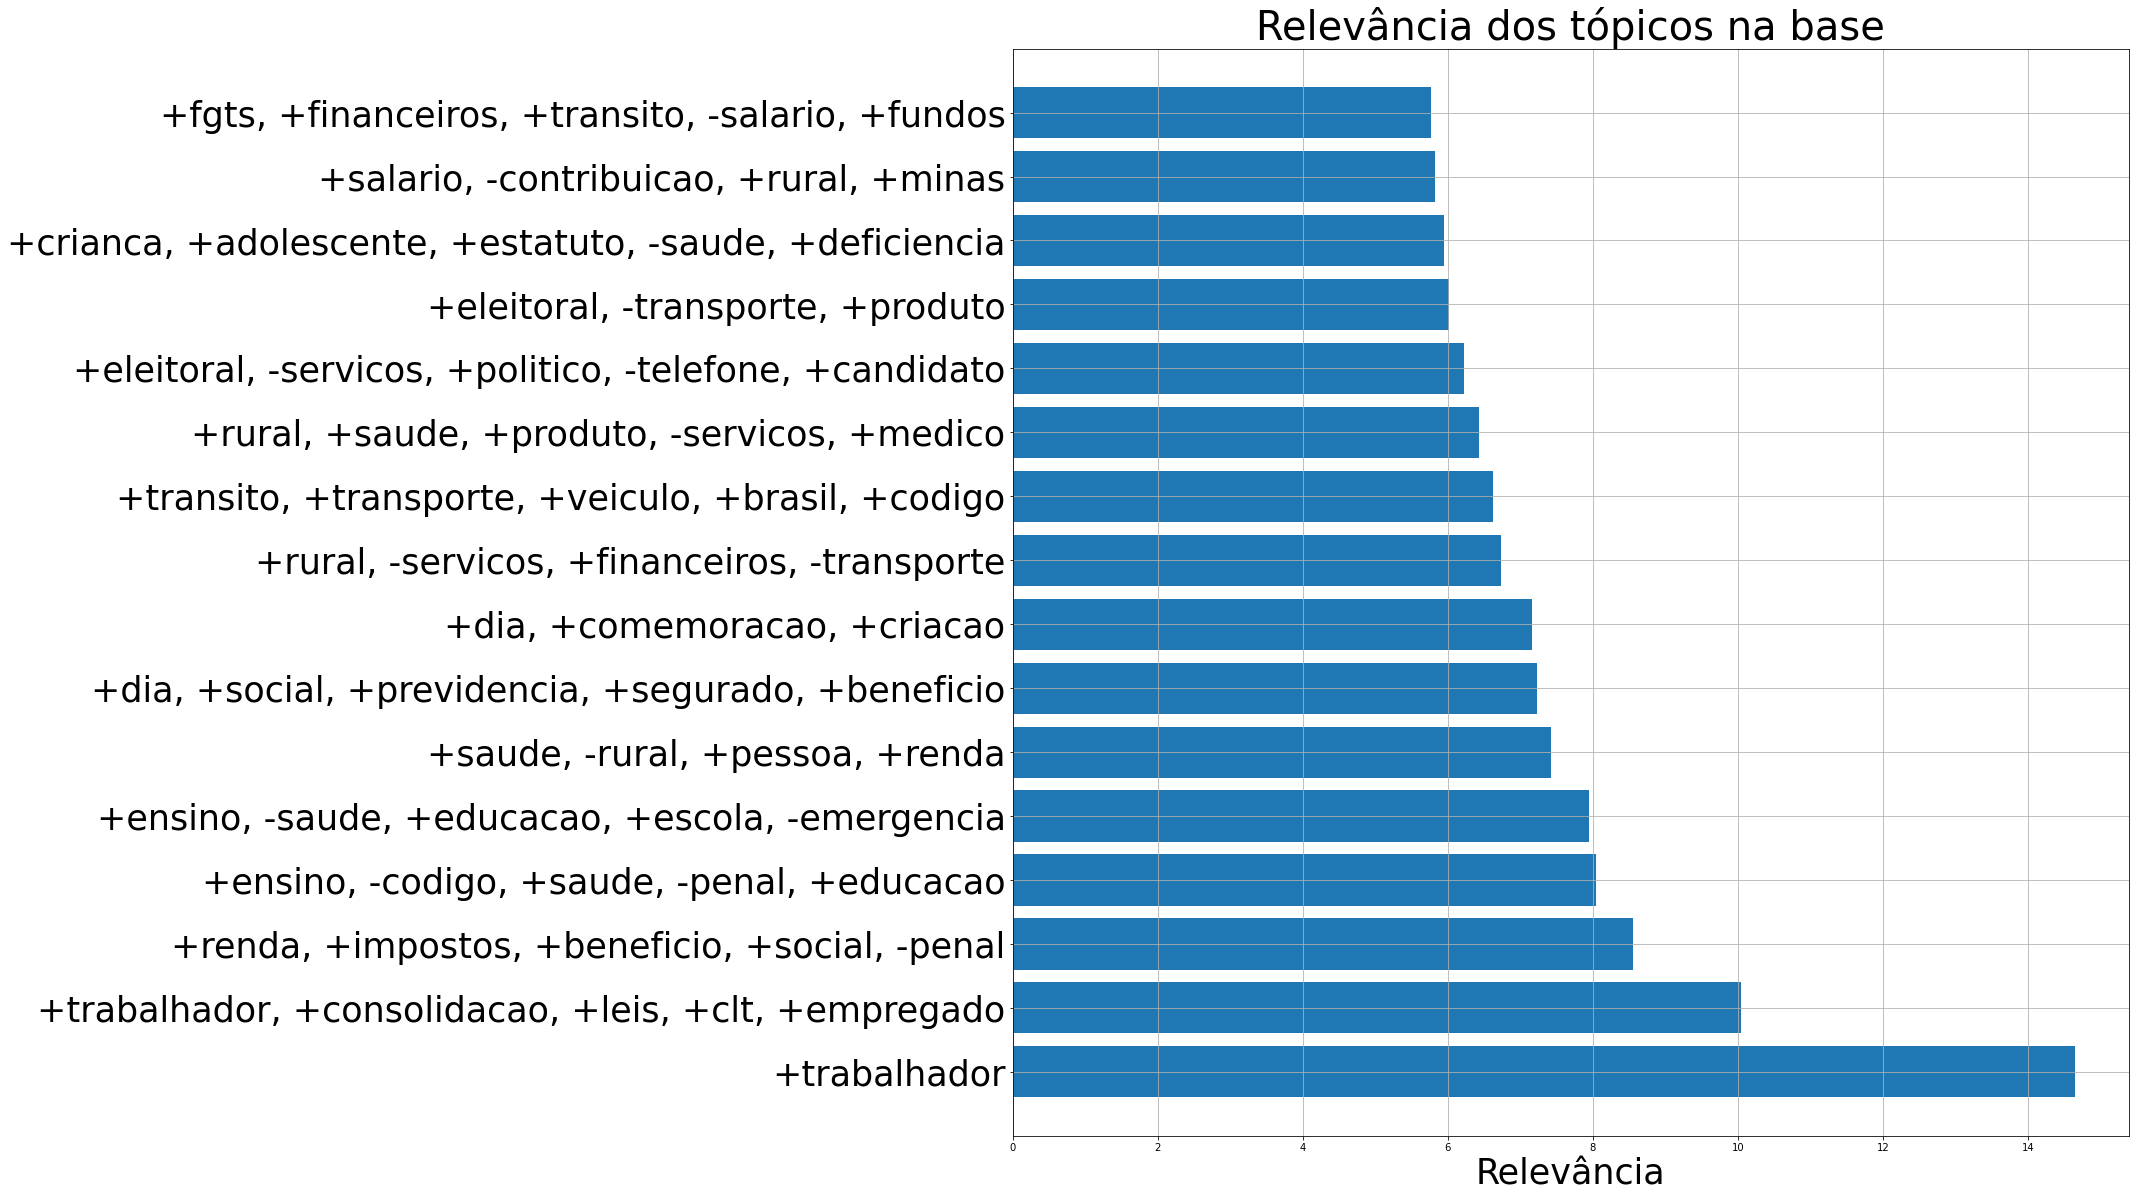

In [ ]:
y_pos = np.arange(len(topics))

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)

ax.grid()
ax.barh(y_pos, Sigma, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(topics, fontsize=35)
ax.set_ylim([-1, num_topics])
ax.set_xlabel('Relevância', fontsize=35)
ax.set_title('Relevância dos tópicos na base', fontsize=40)

plt.show()

In [ ]:
class Topic(str):
  def set_topic(self, topic):
    self.topic = topic
    return self
  
  def __hash__(self):
    topic_hash = (str(self), self.topic)
    return topic_hash.__hash__()

topics_obj = {Topic(stem_to_word[k]).set_topic(i):abs(v) for i, items in enumerate(topics_relevance) for k, v in items}

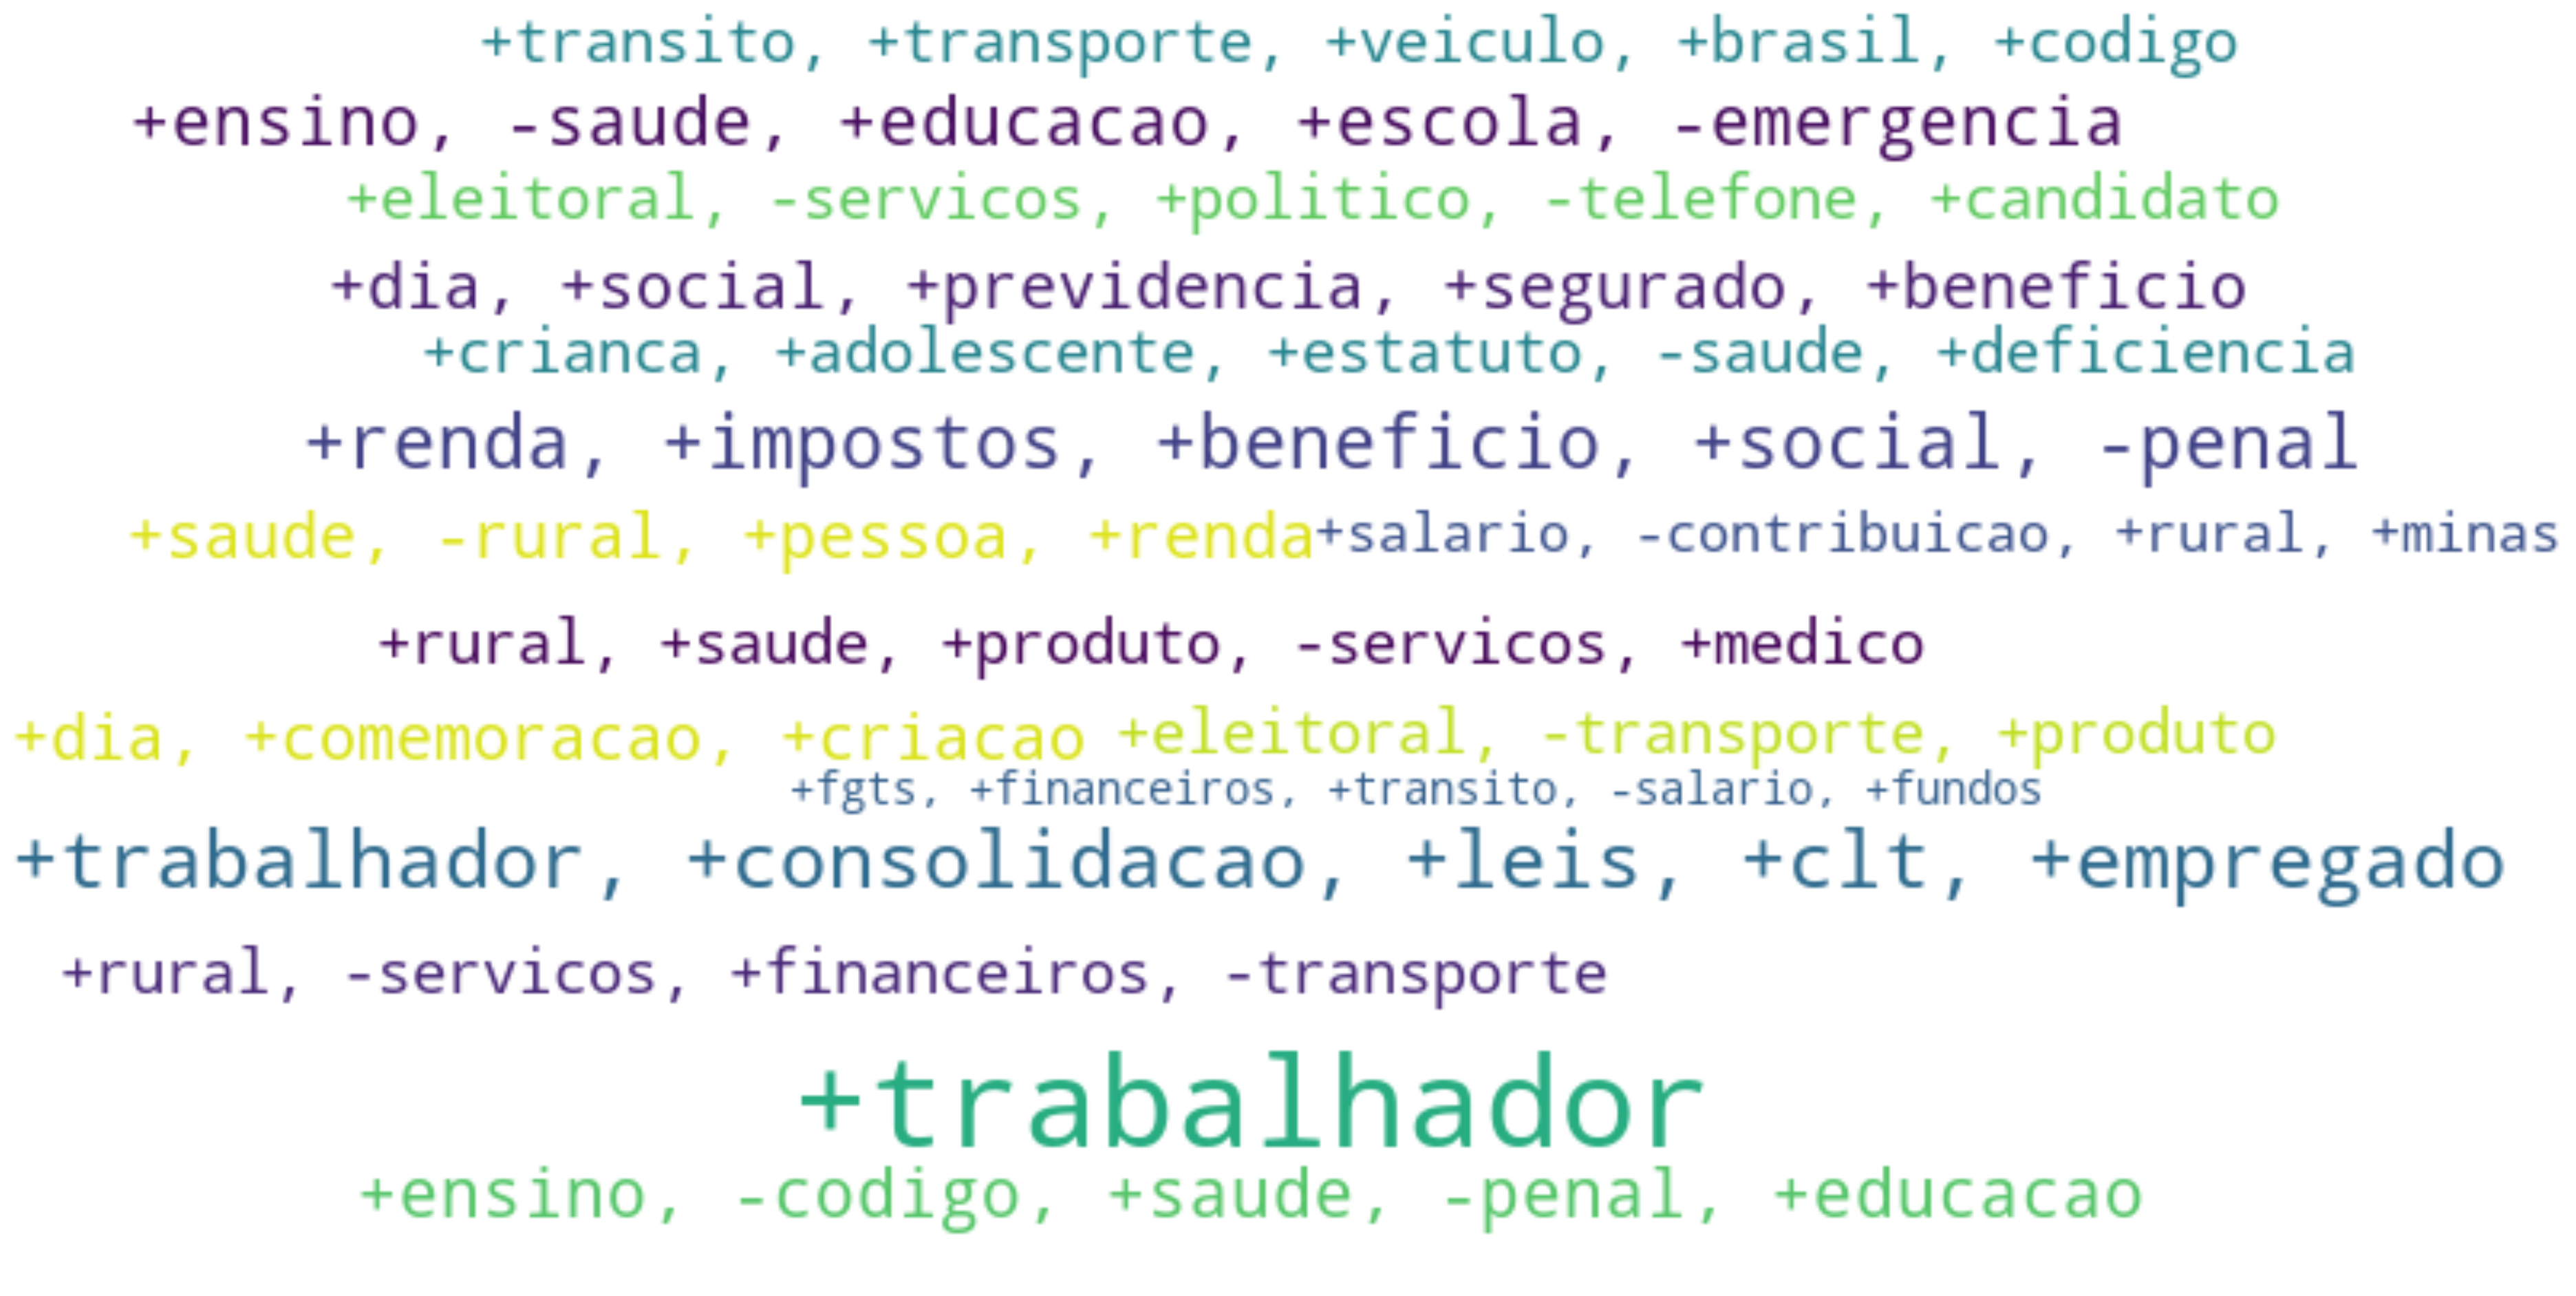

In [ ]:
# topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=max_number_words_per_topic*num_topics, background_color='white').generate_from_frequencies({v:Sigma[i] for i, v in enumerate(topics)})

plt.figure(figsize=(40, 40), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

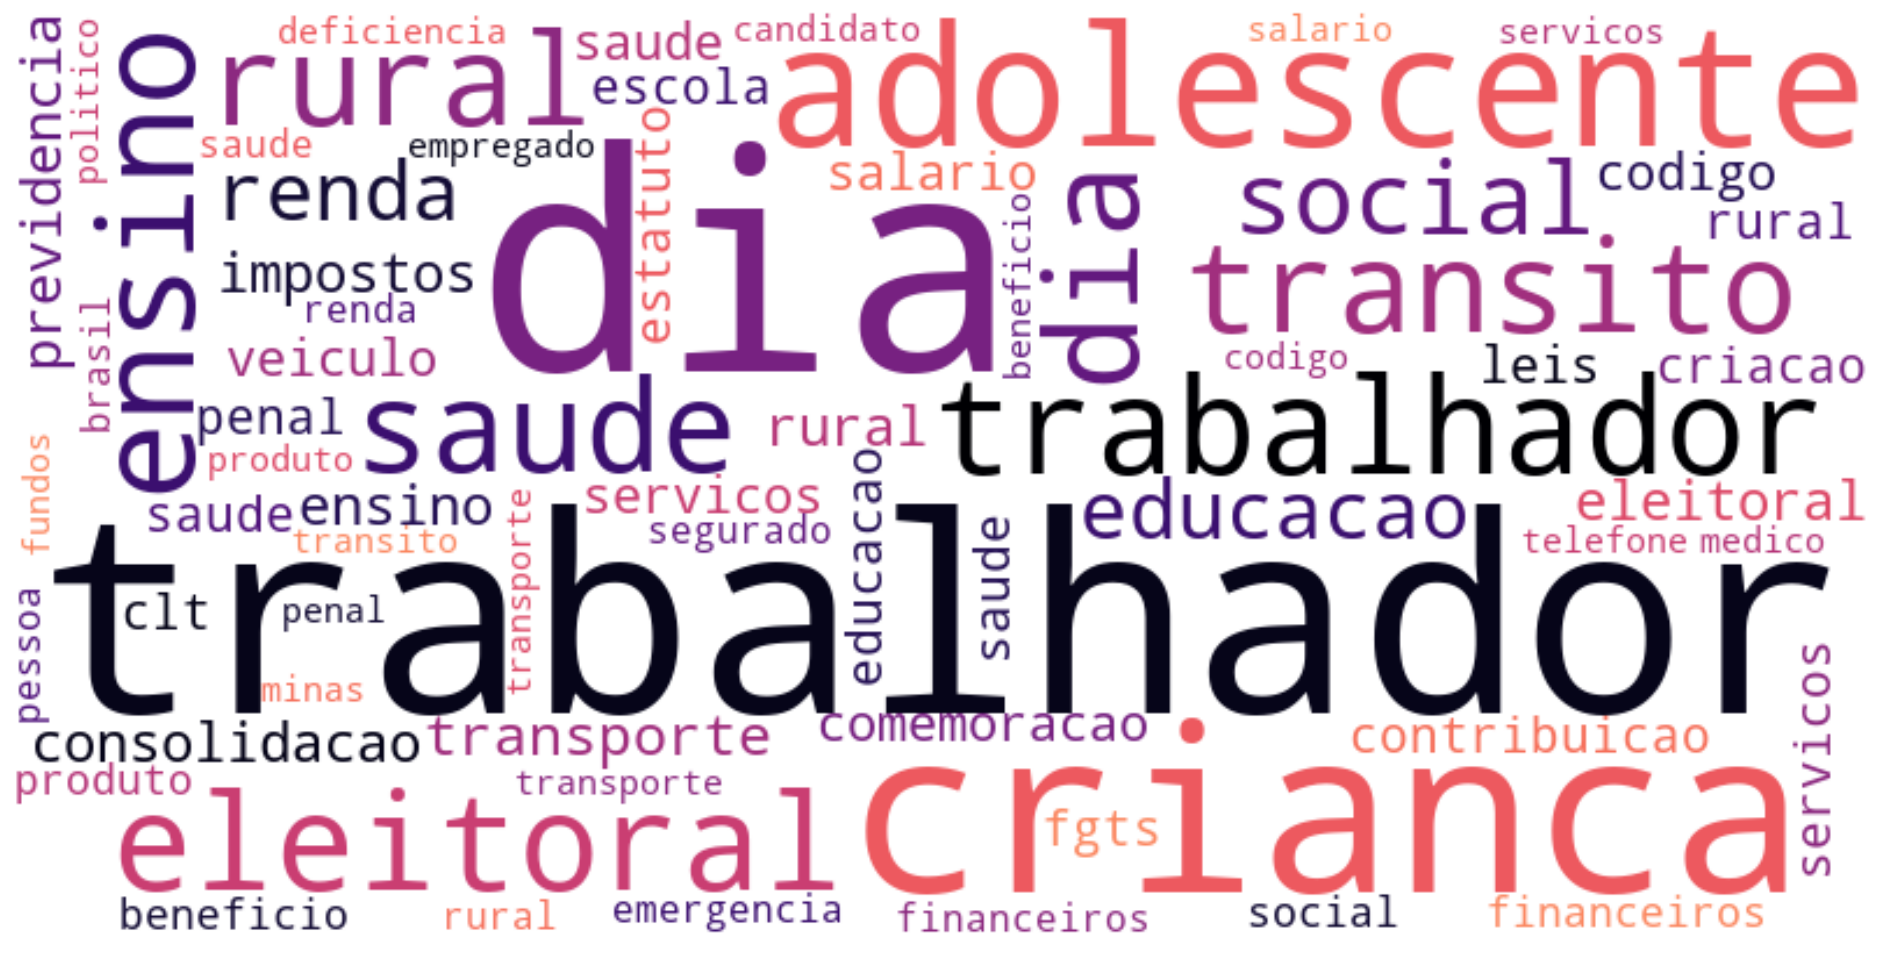

In [ ]:
colormap = matplotlib.cm.get_cmap(name='magma', lut=(num_topics+5))

def topic_color(word, **kwargs):
  r, g, b, a = [int(i*255) for i in colormap(word.topic)]
  return f'rgba({r}, {g}, {b}, {a})'

# word relevance for each topic
wordcloud = WordCloud(width=800, height=400, max_words=max_number_words_per_topic*num_topics, color_func=topic_color, background_color='white').generate_from_frequencies(topics_obj)

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

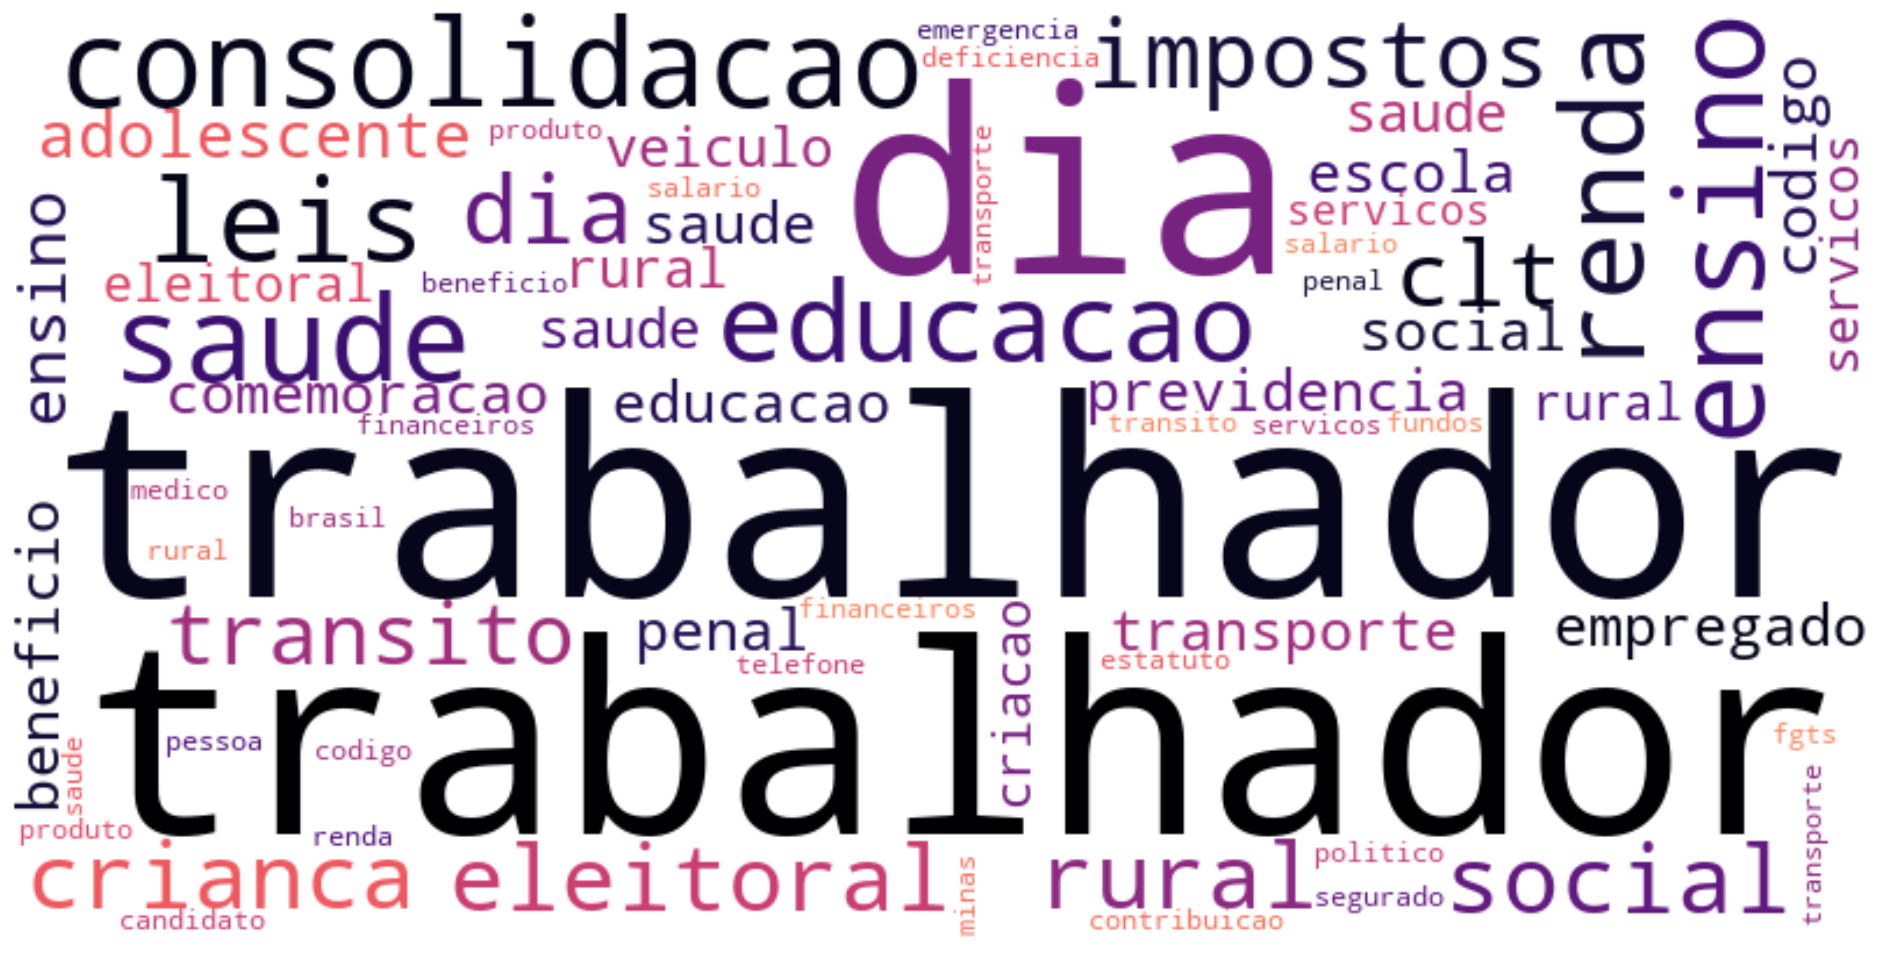

In [ ]:
# word relevance for each topic combined with topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=max_number_words_per_topic*num_topics, color_func=topic_color, background_color='white').generate_from_frequencies({k:v*Sigma[k.topic] for k, v in topics_obj.items()})

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Anotações

**Partidos com mudança de nome ou incorporado a outro:** 

N.A. | Sigla A. | Existência | N.D. | Sigla D. | Motivo
-----|----------|------------|------|----------|-------
20 | 'PJ'   | 1985~1989 | 20 | 'PRN'      | Rebranding apenas?
20 | 'PRN'  | 1989~2000 | 36 | 'PTC'      | Alteração de número e sigla
36 | 'PTC'  | 2000~2021 | 36 | 'Agir'     | Rebranding
###|####### |**2021~**  | 36 | **Agir**   |##############################
70 | 'PTdoB'| 1989~2017 | 70 | 'AVANTE'   | Rebranding
###|####### |**2017~**  | 70 |**Avante**  |##############################
23 | 'PPS'  | 1992~2019 | 23 | 'CIDADANIA'| Rebranding
###|####### |**2019~**  | 23 |**Cidadania**|##############################
27 | 'PSDC' | 1997~2018 | 27 | DC         | Rebranding para "Democracia Cristã"
###|####### |**2018~**  | 27 |**DC**      |##############################
15 | 'MDB*' | 1966~1979 | 15 | 'PMDB'     | Rebranding
N/A| 'PP**' | 1979~1982 | 15 | 'PMDB'     | Incorporação
15 | 'PMDB' | 1980~2017 | 15 | 'MDB'      | Rebranding
###|####### |**2017~**  | 15 |**MDB**     |##############################
56 | 'PRONA'| 1989~2006 | 22 | 'PR'       | Incorporação pelo PL => PR
22 | 'PL'   | 1985~2006 | 22 | 'PR'       | Rebranding pós-fusão com o PRONA
22 | 'PR'   | 2006~2019 | 22 | 'PL'       | Rebranding
###|####### |**2019~**  | 22 |**PL**      |##############################
44 | 'PRP'  | 1989~2019 | 70 | 'Patriota' | Incorporado ao Patriota por cláusula de barreira
51 | 'PEN'  | 2011~2017 | 51 | 'PATRIOTA' | Rebranding pós-fusão com o PRP
###|####### |**2017~**  | 51 |**Patriota**|##############################
19 | 'PTN'  | 1995~2016 | 19 | 'PODE'     | Rebranding
31 | 'PHS'  | 1995~2019 | 19 | 'PODE'     | Incorporação 
###|####### |**2016~**  | 19 |**Podemos** |##############################
N/A| 'PRP*' | 1945~1965 | N/A| 'ARENA'    | Ditadura
N/A| 'PSP'  | 1946~1965 | N/A| 'ARENA'    | Ditadura
N/A| 'UDN'  | 1945~1965 | N/A| 'ARENA'    | Ditadura
N/A| 'ARENA'| 1966~1979 | 11 | 'PDS'      | Rebranding pós-bipartidarismo
11 | 'PDS'  | 1980~1993 | 11 | 'PPR'      | 'PPR': Fusão do PDS com o PDC
17 | 'PDC'  | 1985~1993 | 11 | 'PPR'      | 'PPR': Fusão do PDS com o PDC
28 | 'PTR'  | 1985~1993 | 39 | 'PP'       | 'PP' Fusão do PTR com o PST
52 | 'PST'  | 1988~1993 | 39 | 'PP'       | 'PP' Fusão do PTR com o PST
11 | 'PPR'  | 1993~1995 | 11 | 'PPB'      | 'PPB': Fusão do PPR com o PP
39 | 'PP'   | 1993~1995 | 11 | 'PPB'      | 'PPB': Fusão do PPR com o PP
11 | 'PPB'  | 1995~2003 | 11 | 'PP'       | Rebranding para PP
11 | 'PP'   | 2003~2017 | 11 | 'PP'       | Rebranding para "Progressistas"
###|####### |**2017~**  | 11 |**Progressistas**|##############################
10 | 'PMR'  | 2003~2006 | 10 | 'PRB'      | Rebranding
10 | 'PRB'  | 2006~2019 | 10 | 'REPUBLIC' | Rebranding
###|####### |**2019~**  | 10 |**Republicanos**|##############################
77 | 'SDD'  | 2013~2015 | 77 | 'SD'       | Rebranding da sigla
77 | 'SD'   | 2015~2016 | 77 | 'SOLIDARI' | Rebranding para "Solidariedade" 
###|####### |**2016~**| 77 |**Solidariedade**|##############################
25 | 'PFL'  | 1985~2007 | 25 | 'DEM'      | Rebranding
25 | 'DEM'  | 1985~2022 | 44 | 'UNIÃO'    | 'UNIÃO': Fusão do DEM com o PSL
17 | 'PSL'  | 1994~2022 | 44 | 'UNIÃO'    | 'UNIÃO': Fusão do DEM com o PSL
###|####### |**2022~**  | 44 |**União**   |##############################
26 | 'PAN'  | 1995-2006 | 14 | 'PTB'      | Incorporado ao PTB por cláusula de barreira


